# Машинное обучение, ФКН ВШЭ
## Практическое задание 3.

__Дата выдачи: 14.11.2016__
__Дедлайн: 28.11.2016 05:59__

Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI. 

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования). 

Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: HW3_Username.ipynb, где Username — Ваша фамилия и инициалы на латинице (например, HW3_IvanovII.ipynb). Далее отправьте этот файл на hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+141@gmail.com для студентов группы БПМИ-141).

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [3]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

32.779259161591092

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.764099600922524

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [61]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.3 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [64]:
from sklearn.tree import DecisionTreeRegressor

def DecisionTreeRegressorFit(samples_num, sample_size, depth=None):
    plt.figure(figsize=(12, 7))
    plt.plot(linspace, f(linspace), 'red',)
    if (depth):
        clf = DecisionTreeRegressor(max_depth=depth)
    else:
         clf = DecisionTreeRegressor()

    m = np.zeros(1000)

    for i in range(samples_num):
        samples = np.random.exponential(size=sample_size)
        y = np.random.uniform(low=-1.0, high=1.0, size=sample_size) +  f(samples)
        clf.fit(samples[:, np.newaxis], y)
        y_pred = clf.predict(linspace[:, np.newaxis])
        plt.plot(linspace, y_pred, "gray", alpha=0.5)
        m += y_pred
    plt.plot(linspace, m / samples_num, "black",)

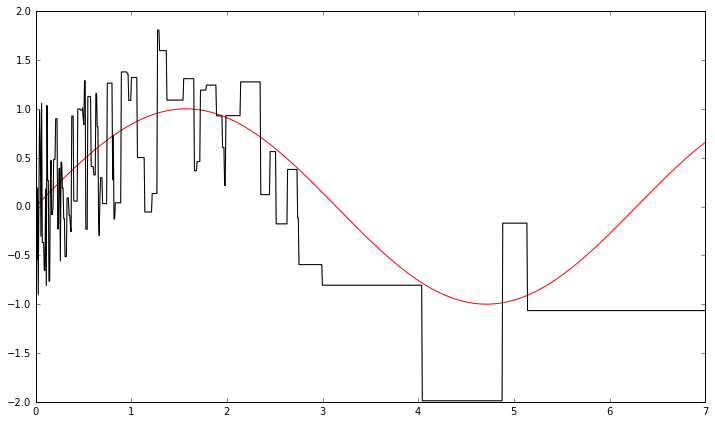

In [67]:
DecisionTreeRegressorFit(1, sample_size, )

__2 (0.3 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

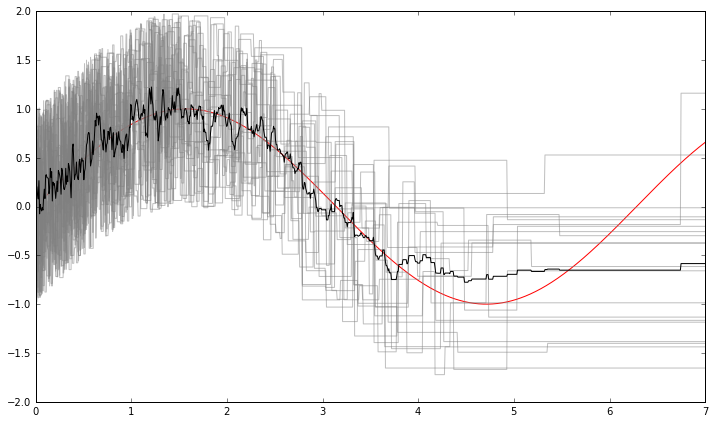

In [68]:
DecisionTreeRegressorFit(samples_num, sample_size, )

__3 (0.1 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

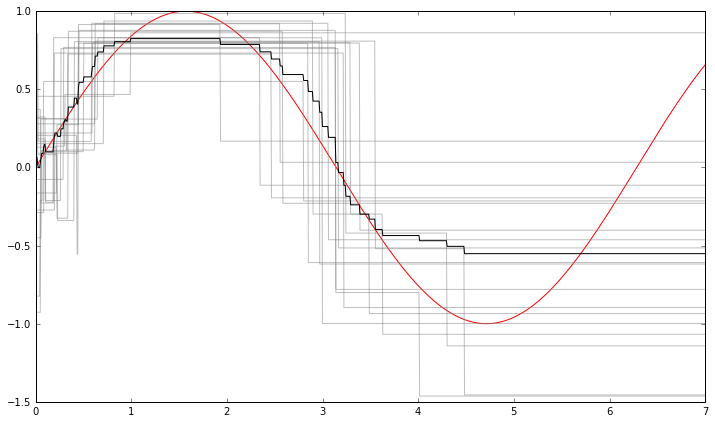

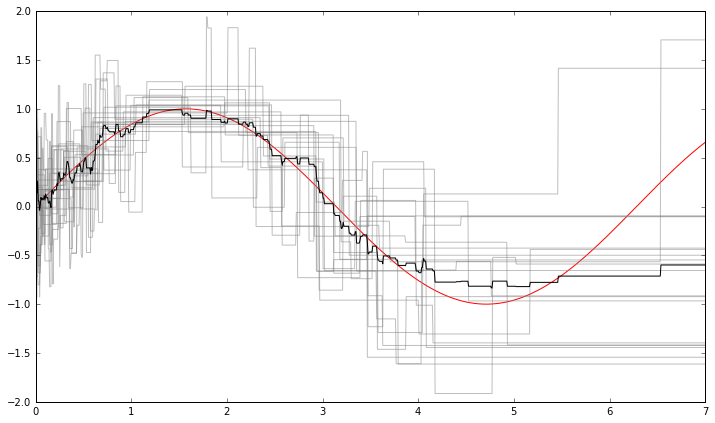

In [69]:
DecisionTreeRegressorFit(samples_num, sample_size, 2)
DecisionTreeRegressorFit(samples_num, sample_size, 4)

__4 (0.3 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

при ограничении глубины дерева 4 можно утверждать, что смещение решающего дерева близко к нулю



#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте - это сумма значения истинной функции на объекте плюс шумовая компонента, также сгенерированная из некоторого распределения.

__4 (1 балл) __Реализуйте функцию:

In [141]:
def compute_bias_variance(regressor, dependence_fun, x_generator=np.random.uniform, noise_generator=np.random.uniform,
                          sample_size=100, samples_num=100, objects_num=50):
    objects = x_generator(size=objects_num)
    ans = dependence_fun(objects)
    noise = noise_generator(size=objects_num)
    ans_with_noise = ans + noise
    
    Eyx = ans + noise.mean()

    variances = np.zeros(objects_num)
    EmuX = np.zeros(objects_num)
    for i in range(samples_num):
        x = x_generator(size=sample_size)
        y = dependence_fun(x) + noise_generator(size=sample_size)
        regressor.fit(x[:, np.newaxis], y)
        y_pred = regressor.predict(objects[:, np.newaxis])
        
        EmuX += y_pred
        variances += (y_pred - EmuX / (i + 1))**2
        
    bias = ((EmuX / samples_num - Eyx)**2).mean()
    variances = variances.mean() / samples_num
    return (bias, variances)

Параметры:
* regressor: объект sklearn-класса, реализующего регрессионный алгоритм (например, DecisionTreeRegressor, LinearRegression, Lasso, RandomForestRegressor ...)
* dependence_fun: функция, задающая истинную зависимость в данных. Принимает на вход вектор и возвращает вектор такой же длины. Примеры: np.sin, lambda x: x\*\*2.
* x_generator: функция, генерирующая одномерную выборку объектов и имеющая параметр size (число объектов в выборке). По умолчанию np.random.uniform.
* noise_generator: функция, генерирующая одномерную выборку шумовых компонент (по одной на каждый объект) и имеющая параметр size (число объектов в выборке). По умолчанию np.random.uniform.
* sample_size: число объектов в выборке.
* samples_num: число выборок, которые нужно сгенерировать, чтобы оценить интеграл по X
* objects_num: число объектов, которые нужно сгенерировать, чтобы оценить интеграл по x.

Вовращаемые значения:
* Смещение алгоритма regressor (число)
* Разброс алгоритма regressor (число)

_Рекомендации:_ 
* Создайте вектор объектов для оценивания интеграла по $x$, затем вектор правильных ответов на нем и вектор зашумленных правильных ответов. $\mathbb{E}[y|x]$ оценивается как сумма правильного ответа на объекте и мат. ожидания шума (который оценивается генерацией отдельной шумовой выборки длины objects_num и усреднением значений в ней). $\mathbb{E}_X [\mu(X)]$ оценивается как в предыдущей задаче: нужно обучить regressor на samples_num выборках длины sample_size и усреднить предсказания на сгенерированных ранее объектах. Смещение - это среднее квадрата разности вектора зашумленных ответов и вектора предсказаний. Для оценки разброса нужно еще раз сгенерировать samples_num выборок.
* Проверить правильность реализации можно на примерах, которые разбирались на семинаре и в домашней работе.

__5 (0.4 балла) Заполните таблицу.__ 

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [143]:
regressors = [LinearRegression(), 
              DecisionTreeRegressor(), 
              RandomForestRegressor(),
              GradientBoostingRegressor()]
generators = [lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              np.random.uniform]

In [144]:
bias = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                      index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
variance = pd.DataFrame(columns=bias.columns, index=bias.index)

In [145]:
bias

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,NaN,NaN,NaN,NaN
DecisionTree,NaN,NaN,NaN,NaN
RandomForest,NaN,NaN,NaN,NaN
GradientBoosting,NaN,NaN,NaN,NaN


In [146]:
from sklearn.linear_model import LinearRegression
from math import *
import pandas as pd
compute_bias_variance(LinearRegression(), lambda x: 5*np.sin(10*x), lambda size: np.random.normal(0, 0.3, size=size))

(11.619441362028898, 0.22374679809682857)

In [165]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

res = [
    [
        compute_bias_variance(LinearRegression(), lambda x: 5*np.sin(10*x), lambda size: np.random.normal(0, 0.3, size=size)),
        compute_bias_variance(LinearRegression(), lambda x: 5*np.sin(10*x), lambda size: np.random.exponential(0.3, size=size)),
        compute_bias_variance(LinearRegression(), lambda x: 5*np.sin(10*x), lambda size: np.random.uniform(-1, 1, size=size)),
        compute_bias_variance(LinearRegression(), lambda x: 5*np.sin(10*x), lambda size: np.random.uniform(0, 1, size=size)),
    ],[
        compute_bias_variance(DecisionTreeRegressor(), lambda x: 5*np.sin(10*x), lambda size: np.random.normal(0, 0.3, size=size)),
        compute_bias_variance(DecisionTreeRegressor(), lambda x: 5*np.sin(10*x), lambda size: np.random.exponential(0.3, size=size)),
        compute_bias_variance(DecisionTreeRegressor(), lambda x: 5*np.sin(10*x), lambda size: np.random.uniform(-1, 1, size=size)),        
        compute_bias_variance(DecisionTreeRegressor(), lambda x: 5*np.sin(10*x), lambda size: np.random.uniform(0, 1, size=size)),   
    ],[
        compute_bias_variance(RandomForestRegressor(), lambda x: 5*np.sin(10*x), lambda size: np.random.normal(0, 0.3, size=size)),
        compute_bias_variance(RandomForestRegressor(), lambda x: 5*np.sin(10*x), lambda size: np.random.exponential(0.3, size=size)),
        compute_bias_variance(RandomForestRegressor(), lambda x: 5*np.sin(10*x), lambda size: np.random.uniform(-1, 1, size=size)),        
        compute_bias_variance(RandomForestRegressor(), lambda x: 5*np.sin(10*x), lambda size: np.random.uniform(0, 1, size=size)),
    ],[
        compute_bias_variance(GradientBoostingRegressor(), lambda x: 5*np.sin(10*x), lambda size: np.random.normal(0, 0.3, size=size)),
        compute_bias_variance(GradientBoostingRegressor(), lambda x: 5*np.sin(10*x), lambda size: np.random.exponential(0.3, size=size)),
        compute_bias_variance(GradientBoostingRegressor(), lambda x: 5*np.sin(10*x), lambda size: np.random.uniform(-1, 1, size=size)),          
        compute_bias_variance(GradientBoostingRegressor(), lambda x: 5*np.sin(10*x), lambda size: np.random.uniform(0, 1, size=size)),

    ]
]

In [166]:
bias_matrix = []

for i in range(4):
    r = []
    for j in range(4):
        r += [res[i][j][0]]
    bias_matrix += [r]
    
variance_matrix = []

for i in range(4):
    r = []
    for j in range(4):
        r += [res[i][j][1]]
    variance_matrix += [r]
    
bias = pd.DataFrame(data=bias_matrix, columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                      index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
variance = pd.DataFrame(data=variance_matrix, columns=bias.columns, index=bias.index)

In [167]:
bias

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,10.577164,8.085119,11.557287,9.574060
DecisionTree,0.115219,0.041698,0.003828,0.003216
RandomForest,0.018785,0.757887,0.009701,0.003132
GradientBoosting,0.088632,0.438630,0.024841,0.002718


In [168]:
variance

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.294767,0.235915,0.184365,0.148693
DecisionTree,0.382452,0.418065,0.296080,0.136111
RandomForest,0.189956,0.492257,0.235166,0.090777
GradientBoosting,0.417854,1.225352,0.256267,0.107586


__6 (0.6 балла) Проанализируйте полученные таблицы. Ответьте на вопросы:__
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?
* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)? 
* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?

DecisionTree
RandomForest
GradientBoosting
LinearRegression


видно что у GradientBoosting имеется и очень большое зачение 1.225352 и достаточное маленькое  0.107586 -- так что смещение и разброс алгоритма определяются не только самим алгоритмом и зависят от вероятностной модели данных

смещение велико для exponential(0.3)


__6* (0.5 доп. балла)__

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

### II. Решающие деревья своими руками
#### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__7 (0.5 балла)__

Реализуйте следующую функцию:

In [45]:
from scipy.stats import mode

def find_best_split(feature_vector, target_vector):
    vector = list(zip(feature_vector, target_vector))
    vector = sorted(vector, key=lambda a_entry: a_entry[0]) 
    feature_vector, target_vector = list(zip(*vector))
    
    unique_f  = np.unique(feature_vector)
    unique_f = sorted(unique_f)
    
    if len(unique_f) == 1: # если в листе остальсь по данной фиче только объекты одного типа -- не получится их разделить, поэтому
# надо сделать так что бы эта фича не отобалась для разделения
        return (
            unique_f, 
            [-100], 
            unique_f[0],  
            -100, 
            [{'is_final': True, 'class': mode(target_vector)[0][0]}, 
            {'is_final': True, 'class':  mode(target_vector)[0][0]}]
        )
     
    def H(x): # считаем криттерий джинни для разданение по f <= x
        i = min(np.where(feature_vector == x)[0])
        a = sum(target_vector[:i])
        b = sum(target_vector) - a
        j = len(target_vector) - i  
        h1 = 1 - (a/i)**2 - ((i - a)/i)**2
        h2 = 1 - (b/j)**2 - ((j - b)/j**2)
        h = -(i)/ len(feature_vector) * h1 - (len(feature_vector) - i)/ len(feature_vector) * h2
        return (
            h,
            [{'is_final': (a == i) or (a == 0), 'class': target_vector[i - 1]},  # сразу посчитаем дует ли данное -- 
            {'is_final': (b == j) or (b == 0), 'class': target_vector[i]}] # -- разбиение давать листы 
        )
    
    H = np.vectorize(H)
    h = H(unique_f[1:])
    Q = h[0]
    is_fin = h[1]
    
    return (unique_f[1:], Q, unique_f[np.argmax(Q) + 1],  max(Q), is_fin[np.argmax(Q)])
    


Параметры:
* feature_vector: вещественнозначный вектор значений признака (np.array)
* target_vector: вектор классов объектов (np.array). len(feature_vector)==len(target_vector).

Возвращаемые значения:
* thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно разделить на две различные подвыборки, или поддерева (np.array)
* ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds. (np.array, len(ginis)==len(thresholds))
* оптимальный порог (число)
* оптимальное значение критерия Джини (число)

Под критерием Джини здесь подразумевается следующая функция:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r),$$
$R$ - множество объектов, $R_l$ и $R_r$ - объекты, попавшие в левое и правое поддерево, $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ - доля объектов класса 1 и 0 соответственно.

Указания:
* Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
* Поведение функции в случае константного признака может быть любым
* За наличие в функции циклов балл будет снижен. Векторизуйте! :)

__8 (0.5 балла)__
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах,а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог - значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака - класс" для всех пяти признаков.

In [46]:
df = pd.read_csv('/Users/nastyats/Downloads/students.csv')

In [47]:
df.shape

(258, 6)

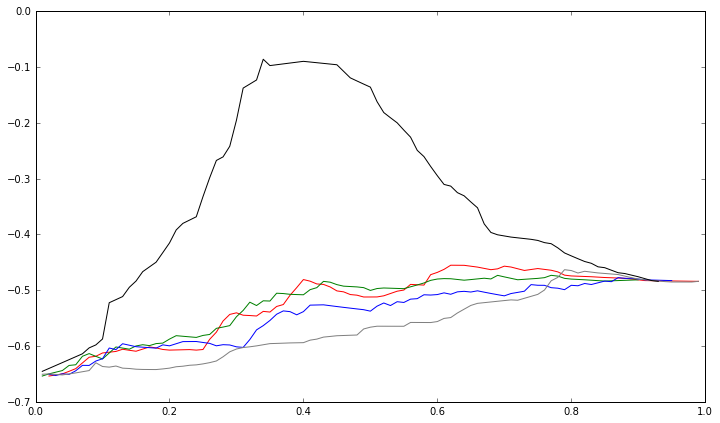

In [49]:
plt.figure(figsize=(12, 7))
cols = ['r', 'g', 'blue',  'grey', 'black']
ind = 0
for c in df.columns:
    if c == ' UNS':
        continue
    feature_vector, Q, a, b, c = find_best_split(df[c].tolist(), df[' UNS'].tolist())
    plt.plot(feature_vector, Q, cols[ind])
    ind += 1


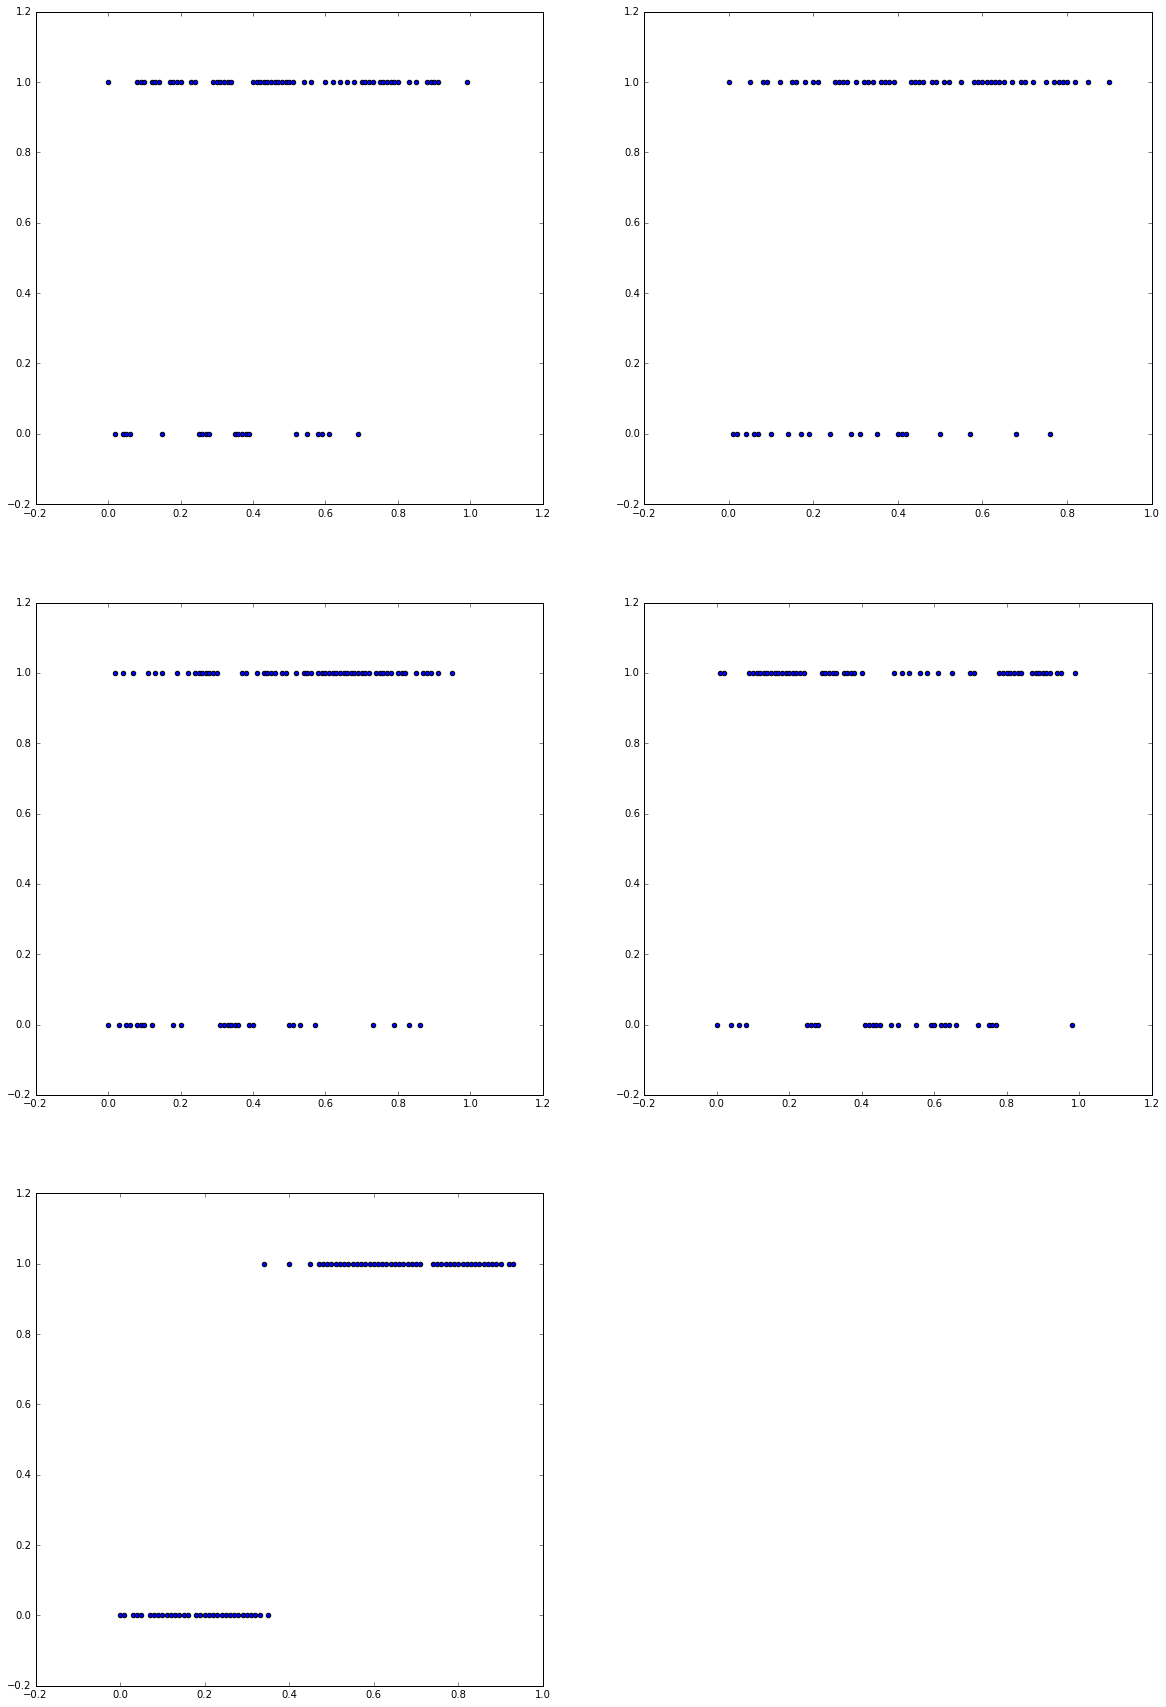

In [50]:
plt.figure(figsize=(20, 30))
cols = ['r', 'g', 'blue', 'black', 'grey']
ind = 0
for c in df.columns:
    if c == ' UNS':
        continue
    
    grouped = df.groupby(c)
    df2 = grouped.agg({' UNS' : np.mean})
    df2[' UNS'][df2[' UNS'] >= 0.5] = 1
    df2[' UNS'][df2[' UNS'] < 0.5] = 0
    plt.subplot(3, 2, ind + 1)
    plt.scatter(df2.index.values, df2[' UNS'].tolist())
    ind += 1


__9 (0.5 балла)__ Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

признаки по которым стоит делить выборку имеют выраженный максимум на графике притерия джинни -- из примера можно увидеть что на scatter-графике у пятого признака явное деление в 0.4 а на граффике значения критерия максимум в 0.4 

кривые для признаков, по которым деление практически невозможно не имеют ярковыраженных максимумов

__10 (1.5 балла).__
Реализуйте класс для обучения решающих деревьев. Мы не будем усложнять класс множеством параметров, как в sklearn. Требования к классу:
* Единственный параметр дерева - вектор, задающий типы признаков: если в позиции i стоит 0, то с признаком номер i нужно работать как с вещественным, если 1 - как с категориальным.
* Чтобы классификатор "распознавался" функциями sklearn, необходимо наследовать его от BaseEstimator. 
* У класса должно быть реализовано два метода: fit и predict. Метод fit принимает на вход двумерный np.array - матрицу объекты-признаки и одномерный вектор ответов y, внутри метода происходит обучение дерева. Метод predict принимает на вход двумерную матрицу объекты-признаки (np.array) и возвращает вектор предсказанных классов (одномерный np.array) для всех объектов. Будем считать, что одинаковых объектов с разными ответами в выборке нет.
* Построение дерева должно осуществляться согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе "Построение дерева". Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу. Ответ в листе: класс объектов, находящихся в нем. Для категориальных признаков необходимо выполнить преобразование, описанное в лекции в разделе "Учет категориальных признаков".

Далее будут даны рекомендации по реализации решающего дерева. Им следовать необязательно: например, вы можете использовать свою структуру для хранения дерева.
* Дерево можно хранить в виде сложенных списков. Каждая внутренняя вершина дерева - список node длины 4: node[0] хранит индекс признака, по которому в данной вершине делается разбиение, node[1] - порог для разбиения, если i-й признак вещественный, и множество значений признака, с которыми объект попадает в левое поддерево, если i-й признак категориальный, node[2] - левое поддерево (список) и node[3] - правое поддерево (список). В листьях node состоит из единственного элемента - ответа, возвращаемого в этом листе. Пример простого дерева, разделяющего выборку по нулевому признаку по порогу 5 на два листа, возвращающих класс 0 и 1: [0, 5, [0], [1]]. Если в левом поддереве корня выполнять разделение по 1-му признаку по порогу 7: [0, 5, [1, 7, [0], [1]], [1]].
* Внутри функции fit определяется рекурсивная функция fit_node(subX, suby, node), принимающая матрицу объекты-признаки subX и ответы на этих объектах suby, а также ссылку на пустой список node - вершину, в которой необходимо выполнить разбиение на две подвыборки. Функция fit_node должна заполнить этот список вызовами node.append(.....). Если suby состоит из одинаковых значений, нужно добавить к node это значение и выйти. Иначе выполнить перебор по всем признакам: для каждого признака с помощью функции find_best_split найти наилучшее разбиение и выбрать признак, дающий максимальное значение критерия Джини. Для категориальных признаков нужно выполнить специальное преобразование (см. лекцию). Вершину нужно заполнить индексом выбранного признака, порогом или множеством значений (задающих разбиение), а затем рекурсивно вызвать fit_node для левого и правого поддерева.
* Внутри функции predict также определяется рекурсивная функция predict_node(x, node), принимающая один объект и вершину. Она проверяет, является ли node листом (это можно определить по длине списка), если да - возвращает node[0], т. е. класс, задаваемый этим листом. Иначе функция определяет, к какому поддереву относится объект, и рекурсивно вызывает себя для этого поддерева.
* В процессе тестирования кода может оказаться, что рекурсивные вызовы повторяются бесконечно. Так происходит, если в одно из поддеревьев попадает пустая подвыборка. Этого быть не должно: пороги, при которых все объекты попадают в одно поддерево, не рассматриваются (см. указания к функции find_best_split).
* Дерево должно давать единичную долю верных ответов на обучающей выборке.
* Протестировать, правильно ли выполняется преобразование категориальных признаков, можно на простой синтетической выборке с одним категориальным признаком, по которому объекты идеально делятся на два класса, и при этом такого эффекта нельзя достичь установкой порога на этот признак.

In [31]:
from sklearn.base import BaseEstimator

In [70]:
### Шаблон класса, удовлетворяющего требованиям

class Node:
    def __init__(self, id = -1):
        self.id = id
        self.feature_name = -1
        self.feature_value = 0
        self.l_node_id = -1
        self.r_node_id = -1
        self.is_final = True
        self.result_class = 0
        
    def add_feature(self, feature_name, feature_value):
        self.feature_name = feature_name
        self.feature_value = feature_value
        
    def get_next_vertex_id(self, object_features):
        if object_features[self.feature_name] >= self.feature_value:
            return self.r_node_id
        else:
            return self.l_node_id

class DecisionTree(BaseEstimator):
    def __init__(self, types):
        self.types = types
        root = Node()
        root.id = 1
        root.is_final = False
        self.nodes = {1: root}

    def add_subnodes(self, node):
        l_node = Node(node.id * 2)
        r_node = Node(node.id * 2 + 1)

        self.nodes[l_node.id] = l_node
        self.nodes[r_node.id] = r_node
        node.r_node_id = r_node.id
        node.l_node_id = l_node.id
        
        return (l_node, r_node)
        
    def rec_fit_node(self, node_id, X, y):
        f_vals = [] # значение критерия
        f_ths = [] # опт пороги
        is_fin_node = []
        for c in X.columns:
            feature_vector, Q, val, f_val, is_fin = find_best_split(X[c].tolist(), y)
            f_vals += [f_val]
            f_ths += [val]
            is_fin_node += [is_fin]
       
        feature_id = np.argmax(f_vals)
        feature_name = X.columns[feature_id]
        
        cur_node = self.nodes[node_id]
        cur_node.add_feature(feature_name, f_ths[feature_id])   
        
        l_node, r_node = self.add_subnodes(cur_node)
        
        for (i, node) in [(0, l_node), (1, r_node)]:
                    
            if (is_fin_node[feature_id][i]['is_final']):
                node.is_final = True
                node.result_class = is_fin_node[feature_id][i]['class']
            else:
                node.is_final = False
                new_df = X
                new_df['y'] = pd.Series(y, index=new_df.index.values)
                if i == 0: # left vertex
                    new_df = new_df[new_df[feature_name] < f_ths[feature_id]]
                else: # right vertex
                    new_df = new_df[new_df[feature_name] >= f_ths[feature_id]]
                    
                self.rec_fit_node(node.id, new_df.drop('y', 1), new_df['y'].tolist())


    def encode_features(self, X, y):
        label_enc = preprocessing.LabelEncoder()
        y = label_enc.fit_transform(y)
        for i in range(len(self.types)):
            if self.types[i] == 1:
                label_enc = preprocessing.LabelEncoder()
                X[X.columns[i]] = label_enc.fit_transform(X[X.columns[i]])
                X[X.columns[i]] = pd.Series(self.encode_categor_f(X[X.columns[i]].tolist(), y), index=X.index.values)
        return (X, y)


    def encode_categor_f(self, x, y):
        fr = [0] * (max(x) + 1)

        for i in range(len(x)):
            if y[i] == 1:
                fr[x[i]] += 1

        fr = np.argsort(fr)[::-1]
        new_x = []
        for i in range(len(x)):
            new_x += [np.where(fr == x[i])[0][0]]

        return new_x


    def fit(self, X, y):
        self.rec_fit_node(1, X, y)


    def rec_predict(self, row, node_ind): 
        node = self.nodes[node_ind]
        if (node.is_final):
            return node.result_class
        else:
            if row[node.feature_name] < node.feature_value:
                return self.rec_predict(row, node_ind * 2)
            else:
                return self.rec_predict(row, node_ind * 2 + 1)


    def predict(self, X):
        pred = []
        for index, row in X.iterrows():
            pred += [self.rec_predict(row, 1)]
        return pred

__11 (0.5 балла)__ Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец - это целевая переменная (e-edible, p-poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что - классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [72]:
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split


df = pd.read_csv('/Users/nastyats/Downloads/HW3-data/mushrooms.csv')

tree = DecisionTree([1] * (len(df.columns) - 1))

df, y = tree.encode_features(df.drop('p', 1), df['p'])
df['p'] = pd.Series(y, index=df.index.values)
df_train, df_test = train_test_split(df, test_size = 0.5)


from sklearn.metrics import accuracy_score

tree.fit(df_train.drop('p', 1), df_train['p'].tolist())
y_pred = tree.predict(df_test.drop('p', 1))
print(accuracy_score(df_test['p'], y_pred))    

0.992614475628


__11* (1 доп. балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__12 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nurcery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recom - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам - наборы данных, по столбцам - алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scorer=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [79]:
def accuracy(mask):
    df = pd.read_csv('/Users/nastyats/Downloads/HW3-data/mushrooms.csv')   
    print(df.head(5))
    from sklearn.cross_validation import train_test_split
    tree = DecisionTree(mask)
    df, y = tree.encode_features(df.drop('p', 1), df['p'])
    df['p'] = pd.Series(y, index=df.index.values)
    df_train, df_test = train_test_split(df, test_size = 0.5)
    from sklearn.metrics import accuracy_score
    tree.fit(df_train.drop('p', 1), df_train['p'].tolist())
    y_pred = tree.predict(df_test.drop('p', 1))
    print(accuracy_score(df_test['p'], y_pred))   
    
df = pd.read_csv('/Users/nastyats/Downloads/HW3-data/mushrooms.csv') 
print(accuracy([1] * (len(df.columns) - 1)))


   p  x  s  n  t p.1  f  c n.1  k ... s.2  w w.1 p.2 w.2  o p.3 k.1 s.3  u
0  e  x  s  y  t   a  f  c   b  k ...   s  w   w   p   w  o   p   n   n  g
1  e  b  s  w  t   l  f  c   b  n ...   s  w   w   p   w  o   p   n   n  m
2  p  x  y  w  t   p  f  c   n  n ...   s  w   w   p   w  o   p   k   s  u
3  e  x  s  g  f   n  f  w   b  k ...   s  w   w   p   w  o   e   n   a  g
4  e  x  y  y  t   a  f  c   b  n ...   s  w   w   p   w  o   p   k   n  g

[5 rows x 23 columns]
0.998522895126
None


In [82]:
df = pd.read_csv('/Users/nastyats/Downloads/HW3-data/mushrooms.csv')


tree = DecisionTree([1] * (len(df.columns) - 1))

df, y = tree.encode_features(df.drop('p', 1), df['p'])
enc = preprocessing.OneHotEncoder(sparse=False)

X_cat_np = enc.fit_transform(
    df[
        df.columns
    ]
)
df = pd.DataFrame(data=X_cat_np)
df['p'] = pd.Series(y, index=df.index.values)
df_train, df_test = train_test_split(df, test_size = 0.5)


from sklearn.metrics import accuracy_score

tree.fit(df_train.drop('p', 1), df_train['p'].tolist())
y_pred = tree.predict(df_test.drop('p', 1))
print(accuracy_score(df_test['p'], y_pred))    

1.0


In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
df = pd.read_csv('/Users/nastyats/Downloads/HW3-data/mushrooms.csv') 
x, y = (df.drop('p', 1), df['p'])


__13 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

(・・ ) ?


### III. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__14 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifierЗначение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [301]:
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier


df = pd.read_csv('/Users/nastyats/Downloads/HW3-data/winequality-red.csv', sep=';')
y = df['quality']
x = df.drop('quality', axis=1)
x.head()

clf = DecisionTreeClassifier()
print("DecisionTreeClassifier", cross_val_score(clf, x, y, cv=3, scoring='accuracy').mean())

clf1 = BaggingClassifier(n_estimators=100)
print("BaggingClassifier", cross_val_score(clf1, x, y, cv=3, scoring='accuracy').mean())

clf2 = BaggingClassifier(n_estimators=100, max_features=0.5)
print("BaggingClassifier", cross_val_score(clf2, x, y, cv=3, scoring='accuracy').mean())

clf3 = RandomForestClassifier(n_estimators=100)
print("RandomForestClassifier", cross_val_score(clf3, x, y, cv=3, scoring='accuracy').mean())

DecisionTreeClassifier 0.462789075969
BaggingClassifier 0.550438282687
BaggingClassifier 0.547299656403
RandomForestClassifier 0.561695371169


#### Задача 5. Число деревьев в случайном лесе и в градиентном бустинге
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__15 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

/Users/nastyats/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:267: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


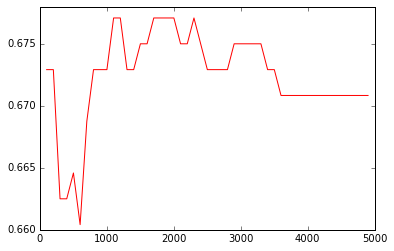

In [305]:
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, y, test_size=0.3, random_state=42)
from sklearn.metrics import accuracy_score


num = 100
clf = RandomForestClassifier(num, warm_start = True)
accur = []
tree_numbers_array = []

while num < 5000:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    clf.set_params(n_estimators = num)
    
    accur += [accuracy_score(y_test, y_pred)]
    tree_numbers_array += [num]
    num += 100
    
plt.plot(tree_numbers_array, accur, 'r')

In [ ]:
по данному графику нельзя сказать что лес переобучается

### IV. P. S.
Если вы добрались до этой ячейки, то скорее всего, вы очень устали и хотите... впрочем, каждый в данной ситуации хочет что-то свое :) Так или иначе, здесь вы можете написать фидбек по заданию: указать, с чем возникли проблемы, что оказалось самым сложным, а что - простым, как можно усовершенствовать задание в будущем. Или просто поделитесь мнением о том, какой фактор будет самым важным при сдаче экзамена по курсу.

(・・ ) ?